# Tutorial - Neural Network - Classification


We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train['price_category']
test_y = test['price_category']

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

In [9]:
# Let's analyze "minimum_nights"

train_inputs['minimum_nights'].describe()

count    2488.000000
mean        2.994775
std         7.105866
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       273.000000
Name: minimum_nights, dtype: float64

In [10]:
train_inputs['minimum_nights'].value_counts()

1      1017
2       666
3       443
4        88
7        82
5        58
10       45
30       18
14       16
15       14
6        12
28        6
20        5
32        3
60        3
9         2
18        1
13        1
8         1
273       1
11        1
21        1
90        1
23        1
17        1
25        1
Name: minimum_nights, dtype: int64

<Axes: >

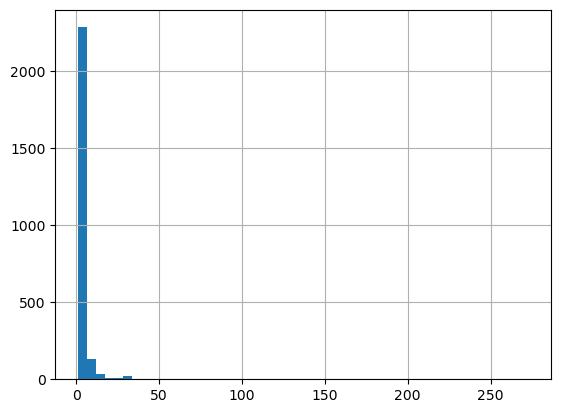

In [12]:
train_inputs['minimum_nights'].hist(bins=50)

#### Create a new categorical column: convert the minimum nights into 4 categories, equally distributed.

In [13]:
# qcut creates n quantiles (it is a discretization technique)
# Let's create 5 quantiles:
pd.qcut(train_inputs['minimum_nights'], 5, duplicates='drop')   

# Notice, it can't do 5 quantiles because of the overlapping edges. It can only 3.

1965    (0.999, 2.0]
1450    (0.999, 2.0]
2503    (3.0, 273.0]
944     (0.999, 2.0]
199     (0.999, 2.0]
            ...     
1130    (0.999, 2.0]
1294    (3.0, 273.0]
860     (0.999, 2.0]
3507    (0.999, 2.0]
3174    (0.999, 2.0]
Name: minimum_nights, Length: 2488, dtype: category
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 3.0] < (3.0, 273.0]]

In [15]:
pd.qcut(train_inputs['minimum_nights'],5, duplicates='drop',
        labels=['low', 'medium', 'high']).value_counts()

low       1683
medium     443
high       362
Name: minimum_nights, dtype: int64

In [16]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['quantile_min_nights'] = pd.qcut(df1['minimum_nights'],5, duplicates='drop',
                        labels=['low', 'medium', 'high'])
    

    return df1[['quantile_min_nights']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

##  Identify the numerical and categorical columns

In [17]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [25]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [26]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [27]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [28]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [29]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [30]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [31]:
feat_eng_columns = ['minimum_nights']

# Pipeline

In [32]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [33]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [34]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [35]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [36]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [37]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         1.        ,  0.        ],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        ,  0.        ]])

In [38]:
train_x.shape

(2488, 69)

# Tranform: transform() for TEST

In [39]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  0.        ],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         1.        ,  0.        ],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  1.        ,
         0.        ,  0.        ]])

In [40]:
test_x.shape

(1067, 69)

# Baseline

In [41]:
# Find percentage
train_y.value_counts()/len(train_y)

btw_$75-$150     0.331190
gte_226          0.235531
btw_$151-$225    0.234325
lte_$75          0.198955
Name: price_category, dtype: float64

# Baseline - new approach (not included in the tutorial video)

**This section is not included in the tutorial video. Though, it is a better (and a more foolproof) way of calculating the baseline. I recommend using this approach rather than the above approach.**

**Note that it generates the same results as the above approach.**

In [42]:
# Sci-kit Learn's DummyClassifier automates the entire process performed manually above.
# First, you instantiate it with the "most_frequent" strategy. 
# Then, you fit the model. This finds the most frequently (i.e., majority) class (in the training set).

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

In [43]:
from sklearn.metrics import accuracy_score

In [44]:
# Then, you call the predict function of the classifier.
# This predicts all values as the majority class.
# In the next step, you compare the predicted values with the actual values to calculate accuracy
# This is the baseline Train Accuracy

dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_y, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.3311897106109325


In [45]:
# We repeat the same steps for the test set
# This is the baseline Test Accuracy

dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_y, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.3402061855670103


# Multiclass classification



In [57]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,))

mlp_clf.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

## Accuracy

In [58]:
from sklearn.metrics import accuracy_score

In [59]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.889871382636656

In [60]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6232427366447985

## Classification Matrix

In [61]:
from sklearn.metrics import confusion_matrix

#We usually create the confusion matrix on test set
confusion_matrix(test_y, test_y_pred)

array([[107,  52,  85,   1],
       [ 43, 226,  24,  70],
       [ 49,  23, 149,   0],
       [ 10,  44,   1, 183]], dtype=int64)

## Increase maximum iterations for convergence

In [62]:
#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, verbose=True)

mlp_clf.fit(train_x, train_y)

Iteration 1, loss = 1.41182652
Iteration 2, loss = 1.19273074
Iteration 3, loss = 1.09279648
Iteration 4, loss = 1.02829395
Iteration 5, loss = 0.98236597
Iteration 6, loss = 0.94773749
Iteration 7, loss = 0.92050194
Iteration 8, loss = 0.89842055
Iteration 9, loss = 0.87920322
Iteration 10, loss = 0.86334943
Iteration 11, loss = 0.84966031
Iteration 12, loss = 0.83716728
Iteration 13, loss = 0.82640662
Iteration 14, loss = 0.81719555
Iteration 15, loss = 0.80887793
Iteration 16, loss = 0.80008048
Iteration 17, loss = 0.79306607
Iteration 18, loss = 0.78569594
Iteration 19, loss = 0.77949117
Iteration 20, loss = 0.77211929
Iteration 21, loss = 0.76703975
Iteration 22, loss = 0.76137903
Iteration 23, loss = 0.75565969
Iteration 24, loss = 0.75086442
Iteration 25, loss = 0.74575198
Iteration 26, loss = 0.73963924
Iteration 27, loss = 0.73658884
Iteration 28, loss = 0.73152358
Iteration 29, loss = 0.72652639
Iteration 30, loss = 0.72155757
Iteration 31, loss = 0.71806350
Iteration 32, los

Iteration 257, loss = 0.26660347
Iteration 258, loss = 0.26627758
Iteration 259, loss = 0.26463406
Iteration 260, loss = 0.26314481
Iteration 261, loss = 0.26255726
Iteration 262, loss = 0.26210489
Iteration 263, loss = 0.26113856
Iteration 264, loss = 0.26057159
Iteration 265, loss = 0.25936012
Iteration 266, loss = 0.25875773
Iteration 267, loss = 0.25833179
Iteration 268, loss = 0.25720297
Iteration 269, loss = 0.25502319
Iteration 270, loss = 0.25321772
Iteration 271, loss = 0.25246230
Iteration 272, loss = 0.25331932
Iteration 273, loss = 0.25214793
Iteration 274, loss = 0.25270007
Iteration 275, loss = 0.25137415
Iteration 276, loss = 0.24853276
Iteration 277, loss = 0.24801670
Iteration 278, loss = 0.24817618
Iteration 279, loss = 0.24535536
Iteration 280, loss = 0.24640540
Iteration 281, loss = 0.24490911
Iteration 282, loss = 0.24408382
Iteration 283, loss = 0.24322926
Iteration 284, loss = 0.24248740
Iteration 285, loss = 0.24134384
Iteration 286, loss = 0.24048464
Iteration 

Iteration 507, loss = 0.11593806
Iteration 508, loss = 0.11671484
Iteration 509, loss = 0.11466431
Iteration 510, loss = 0.11286334
Iteration 511, loss = 0.11365017
Iteration 512, loss = 0.11300268
Iteration 513, loss = 0.11335633
Iteration 514, loss = 0.11213109
Iteration 515, loss = 0.11091638
Iteration 516, loss = 0.11245761
Iteration 517, loss = 0.11108924
Iteration 518, loss = 0.11078783
Iteration 519, loss = 0.11089291
Iteration 520, loss = 0.10946698
Iteration 521, loss = 0.11028311
Iteration 522, loss = 0.10993287
Iteration 523, loss = 0.10878553
Iteration 524, loss = 0.10936977
Iteration 525, loss = 0.11009269
Iteration 526, loss = 0.10935493
Iteration 527, loss = 0.10833026
Iteration 528, loss = 0.10827513
Iteration 529, loss = 0.10710847
Iteration 530, loss = 0.10757313
Iteration 531, loss = 0.10674365
Iteration 532, loss = 0.10576794
Iteration 533, loss = 0.10546778
Iteration 534, loss = 0.10550096
Iteration 535, loss = 0.10637393
Iteration 536, loss = 0.10475258
Iteration 

Iteration 756, loss = 0.05507405
Iteration 757, loss = 0.05534947
Iteration 758, loss = 0.05640424
Iteration 759, loss = 0.05584593
Iteration 760, loss = 0.05480038
Iteration 761, loss = 0.05546167
Iteration 762, loss = 0.05437824
Iteration 763, loss = 0.05446890
Iteration 764, loss = 0.05433228
Iteration 765, loss = 0.05469914
Iteration 766, loss = 0.05425016
Iteration 767, loss = 0.05439925
Iteration 768, loss = 0.05384726
Iteration 769, loss = 0.05391771
Iteration 770, loss = 0.05357155
Iteration 771, loss = 0.05655946
Iteration 772, loss = 0.05497951
Iteration 773, loss = 0.05361173
Iteration 774, loss = 0.05335212
Iteration 775, loss = 0.05274916
Iteration 776, loss = 0.05379792
Iteration 777, loss = 0.05429496
Iteration 778, loss = 0.05356791
Iteration 779, loss = 0.05260102
Iteration 780, loss = 0.05246071
Iteration 781, loss = 0.05251492
Iteration 782, loss = 0.05184763
Iteration 783, loss = 0.05149131
Iteration 784, loss = 0.05170052
Iteration 785, loss = 0.05199334
Iteration 

MLPClassifier(max_iter=1000, verbose=True)

In [63]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9955787781350482

In [64]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.598875351452671

# Change the number of neurons

In [68]:
#Increase neurons from 100 to 50
mlp_clf = MLPClassifier(max_iter=1000, verbose=False,
                        hidden_layer_sizes=(50,))

mlp_clf.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

In [69]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9533762057877814

In [70]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6119962511715089

# Deep Neural Network

In [71]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000)

dnn_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000)

In [72]:
#Let's check the number of iterations:
dnn_clf.n_iter_

287

In [73]:
#Let's check the number of layers: we gave 3 but get 5 coz i/p and o/p included
dnn_clf.n_layers_

5

In [74]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9714630225080386

In [75]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.5857544517338332

# Deeper Neural Network

In [76]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(100,80,60,40,20,10),
                       max_iter=1000)

dnn_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(100, 80, 60, 40, 20, 10), max_iter=1000)

In [77]:
#Let's check the number of iterations:
dnn_clf.n_iter_

128

In [78]:
#Let's check the number of layers:
dnn_clf.n_layers_

8

In [79]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.987540192926045

In [80]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6204311152764761

## Early stopping

In [85]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       early_stopping=True)

dnn_clf.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 25, 10),
              max_iter=1000)

In [86]:
#Let's check the number of iterations:
dnn_clf.n_iter_

30

In [87]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.6495176848874598

In [88]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6457357075913777

## Activation function

In [93]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       activation = 'relu')

dnn_clf.fit(train_x, train_y)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000)

In [94]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.9903536977491961

In [95]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.5913776944704779

## Solver (Optimizer)

In [99]:
#Let's use Stochastic Gradient Descent optimizer

dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000,
                       activation = 'tanh',
                       solver='sgd')

dnn_clf.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25, 10), max_iter=1000,
              solver='sgd')

In [100]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_y, train_y_pred)

0.7508038585209004

In [101]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_y, test_y_pred)

0.6401124648547329

## Prediction probabilities

In [102]:
#Select a random observation

random = test_x[50:51]
random

array([[-0.85449093, -0.64236262, -0.02173662, -0.43231232, -0.32724017,
         0.42133671,  1.25362268, -0.40315781,  1.26658906, -0.14002161,
         2.9856231 ,  1.12556644,  0.55844268,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  1.        ,  0. 

In [103]:
# Observe the input variables of the observation
dnn_clf.predict_proba(random)

array([[0.70995983, 0.25998934, 0.0140241 , 0.01602673]])

In [104]:
# Round the probability values
np.round(dnn_clf.predict_proba(random), 2)

array([[0.71, 0.26, 0.01, 0.02]])

In [105]:
dnn_clf.classes_

array(['btw_$151-$225', 'btw_$75-$150', 'gte_226', 'lte_$75'],
      dtype='<U13')

In [106]:
test_y[50:51]

196    btw_$75-$150
Name: price_category, dtype: object